In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf

In [2]:
# TODO: how to make meta() batched such that N is constant within a batch?
def meta():
    N = np.random.randint(2, 10)
    return dict(N=N)

def prior():
    mu = np.random.normal(0.0, 1.0)
    sigma = np.random.gamma(1, 1)
    return dict(mu = mu, sigma = sigma)

def likelihood(mu, sigma, N):
   # just fix size = 10 for now
   y = np.random.normal(mu, sigma, size = 10)
   return dict(y=y)


In [3]:
# TODO: please let us get rid of the "Lambda" here!
# TODO: why composite and not sequential?
simulator = bf.simulators.CompositeLambdaSimulator([meta, prior, likelihood])

In [4]:
# TODO: why not just 64 instead of (64, )?
sample_data = simulator.sample((64,))

In [5]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['N', 'mu', 'sigma', 'y'])
Types of sample_data values:
	 {'N': <class 'numpy.ndarray'>, 'mu': <class 'numpy.ndarray'>, 'sigma': <class 'numpy.ndarray'>, 'y': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'N': (64, 1), 'mu': (64, 1), 'sigma': (64, 1), 'y': (64, 10)}
Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['N', 'mu', 'sigma', 'y'])
Types of sample_data values:
	 {'N': <class 'numpy.ndarray'>, 'mu': <class 'numpy.ndarray'>, 'sigma': <class 'numpy.ndarray'>, 'y': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'N': (64, 1), 'mu': (64, 1), 'sigma': (64, 1), 'y': (64, 10)}


In [6]:
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["mu", "sigma"],
    inference_conditions=["y"],
)

In [7]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)

In [8]:
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

# TODO: can we add the data_adapter *only* after creating approximator?
# this would shorten the overall code because we wouldn't have to call
# bf.ContinuousApproximator twice
# TODO: when newly building the data_adapter here, 
# we may see an error in .sample later ony
# approximator.build_data_adapter(
#    inference_variables=["mu", "sigma"],
#    inference_conditions=["y"],
#)

# TODO: can we add the inference network *only*  after creating approximator?
# approximator.inference_network = inference_network

In [9]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
approximator.compile(optimizer=optimizer)

In [14]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Obtain samples from amortized posterior
# TODO: can we stop needing the float32 transformation for pytorch?
lik = likelihood(mu=2.0, sigma=2.0, N = 10)
conditions = {"y": lik["y"].astype("float32")}
pdraws = approximator.sample(conditions=conditions, num_samples=num_samples)
pdraws = np.append(pdraws["mu"][0], pdraws["sigma"][0], axis = -1)

(0.0, 5.0)

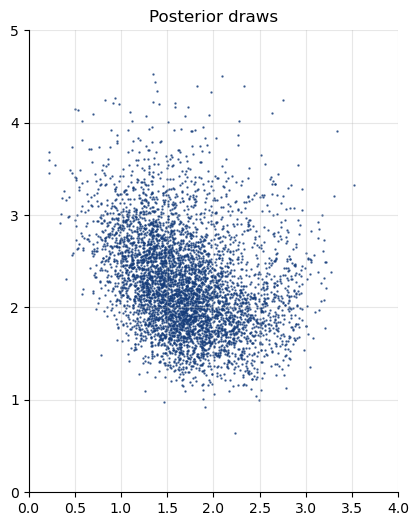

In [15]:
# Prepare figure
f, axes = plt.subplots(1, figsize=(6, 6))

# Plot samples
axes.scatter(pdraws[:, 0], pdraws[:, 1], color="#153c7a", alpha=0.75, s=0.5)
sns.despine(ax=axes)
axes.set_title(r"Posterior draws")
axes.grid(alpha=0.3)
axes.set_aspect("equal", adjustable="box")
axes.set_xlim([0, 4])
axes.set_ylim([0, 5])